In [60]:
# Little Jupyter notebook to explore time series data from in situ stations and satellite observations,
# both already in csv format.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# These two datasets are for the GCNet data
os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/appears_extraction')
all_data_mcd = pd.read_csv('greenland-stations-MCD43A3-006-results.csv', index_col=0)

os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/tower_data/orig_data_std_format/')
stn_df = pd.read_csv('Summit_06c.csv')

# This is the NOAA Summit stn data
# os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/noaa_summit_data')
# stn_df = pd.read_csv('noaa_summit_all.csv')
#
# os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/appears_extraction/noaa_summit')
# all_data_mcd = pd.read_csv('noaa-summit-correct-location-MCD43A3-006-results.csv', index_col=0)

# Column variables for readability
date = 'Date'
mcd43a3_sw_wsa = 'MCD43A3_006_Albedo_WSA_shortwave'
mcd43a3_sw_qa = 'MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave'

# Specify whether to keep QA == 1, i.e. magnitude inversions

all_qa = True

In [61]:
# Subset and mask station data

# Valid dataset options: GCNET, NOAA
dataset = "GCNET"

if dataset == "GCNET":
    # Filter out non-noon observations from dataset
    #TODO Can't figure out why these two filters cannot be combined into single line
    filter = stn_df['dec_day'] % 0.5 == 0
    stn_df.where(filter, inplace = True)

    filter = stn_df['dec_day'] % 1.0 != 0
    stn_df.where(filter, inplace = True)

    # Remove observations filtered out above
    stn_df = stn_df.dropna()

    # Clean up dec_days and combine wit.h year to make new date field in yyyy-mm-dd, use as index
    stn_df['dec_day'] = stn_df['dec_day'].apply(np.floor)
    stn_df['dec_day'] = stn_df['dec_day'].astype(int).astype(str)
    stn_df['dec_day'] = stn_df['dec_day'].str.zfill(3)
    stn_df['date'] = stn_df['year'].astype(int).astype(str) + stn_df['dec_day']
    stn_df['date'] = pd.to_datetime(stn_df['date'], format='%Y%j')
    stn_df = stn_df.set_index(stn_df['date'])

    # Delete now unnecessary dateparts
    del stn_df['year']
    del stn_df['dec_day']

    # Set albedo fill values to NaN
    stn_df['alb'].mask(stn_df['alb'] == 999, np.NaN, inplace=True)
elif dataset == "NOAA":

    # Add column to contain entire date string
    stn_df['date'] = pd.to_datetime(stn_df['Year'].map(str) + "-" + stn_df['Mn'].map(str) + "-" + stn_df['Dy'].map(str))
    # + " " + stn_df['Hr'].map(str) + ":" + stn_df['Mi'].map(str))

    # Note the .copy() prevents the new variable from simply pointing to the original df
    df_selection = stn_df.loc[(stn_df['Hr'] == 12) & (stn_df['Mi'] == 0)].copy()

    # Now that we have our combined date/time col, get rid of these
    del df_selection['Year']
    del df_selection['Mn']
    del df_selection['Dy']
    del df_selection['Hr']
    del df_selection['Mi']

    # These are longwave radiation
    del df_selection['D_IR']
    del df_selection['U_IR']

    # Calculate "albedo" simply as the ratio of upward to downwelling radiance
    df_selection['alb'] = df_selection['U_GLOBAL'] / df_selection['D_GLOBAL']

    # Filter out spurious albedo values (sensor errors?)
    df_selection = df_selection.loc[(df_selection['alb'] < 1.0) & (df_selection['alb'] > 0.0)]

    df_selection = df_selection.set_index(df_selection['date'])

    # Set the selection back to the original df variable to fit into exisiting code.
    stn_df = df_selection.copy()
print(stn_df.head())

            sw_down  sw_up  net_rad   alb       date
date                                                
2015-01-01      0.2   0.18    -2.91  0.85 2015-01-01
2015-01-02      0.2   0.18    -3.07  0.85 2015-01-02
2015-01-03      0.0   0.00   -10.24  0.85 2015-01-03
2015-01-04      0.0   0.00    -7.95  0.85 2015-01-04
2015-01-05      0.2   0.00    -8.27  0.85 2015-01-05


In [62]:
# Subset and mask mcd43 data
mcd_df = all_data_mcd.loc['Summit', [date, mcd43a3_sw_wsa, mcd43a3_sw_qa]]

# Mask out fill values
mcd_df[mcd43a3_sw_wsa].mask(mcd_df[mcd43a3_sw_qa] == 255, np.NaN, inplace=True)

# If specified, remove QA == 1
if all_qa:
    mcd_df[mcd43a3_sw_wsa].mask(mcd_df[mcd43a3_sw_qa] == 1, np.NaN, inplace=True)

print(mcd_df.head())


                Date  MCD43A3_006_Albedo_WSA_shortwave  \
Category                                                 
Summit    2000-02-24                               NaN   
Summit    2000-02-25                               NaN   
Summit    2000-02-26                               NaN   
Summit    2000-02-27                               NaN   
Summit    2000-02-28                               NaN   

          MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave  
Category                                                            
Summit                                                  255         
Summit                                                  255         
Summit                                                  255         
Summit                                                  255         
Summit                                                    1         


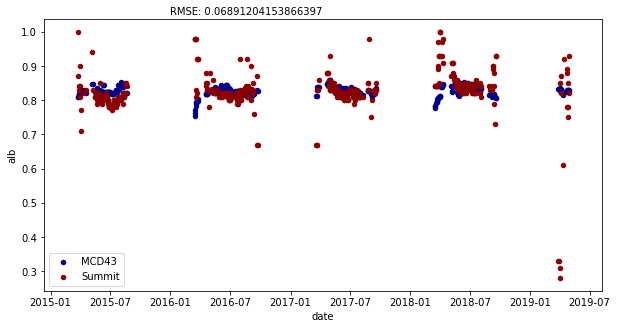

In [63]:
# Plot data
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#plt.style.use("ggplot")

mcd_df[date] = pd.to_datetime(mcd_df[date], yearfirst=True)
mcd_df = mcd_df.set_index(mcd_df[date])

stn_df.set_index(stn_df['date'])

# Join satellite observations to stn data based on date
joined_df = mcd_df.join(stn_df, lsuffix='_mcd', rsuffix='_stn')

if dataset == "GCNET":
    #del joined_df['date']
    del joined_df['MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave']
    del joined_df['sw_down']
    del joined_df['sw_up']
    del joined_df['net_rad']
    del joined_df['Date']
elif dataset == "NOAA":
    del joined_df['MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave']
    del joined_df['Date']
    del joined_df['D_GLOBAL']
    del joined_df['U_GLOBAL']

# Subset dataset to correct time period (different for different stations?
joined_subset_df = joined_df.loc['2015-01-01':'2019-12-01']

# Calculate stats on dataset that has no missing values
joined_subset_no_nans_df = joined_subset_df.dropna()
sw_wsa_mse = mean_squared_error(joined_subset_no_nans_df[mcd43a3_sw_wsa], joined_subset_no_nans_df['alb'])
sw_wsa_rmse = math.sqrt(sw_wsa_mse)

# Do plot
#ax1 = joined_subset_df.plot(kind='scatter', y='alb', x='date', use_index=True)
#joined_subset_df.plot(kind='scatter', y=mcd43a3_sw_wsa, x='date', use_index=True, ax=ax1)

# Add back in the missing days in a plottable way
joined_subset_no_nans_filled_df = joined_subset_no_nans_df.asfreq('D')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax = joined_subset_no_nans_filled_df.plot(kind='scatter', x='date', y=mcd43a3_sw_wsa, color='DarkBlue', label='MCD43')
#ax.text(3, 8, str(sw_wsa_rmse), fontsize=10, verticalalignment='top', bbox=props)
ax.text(pd.Timestamp("2016-01-01"), 1.05, "RMSE: " + str(sw_wsa_rmse))
ax.set_xlabel('Date')
ax.set_ylabel('Albedo')
joined_subset_no_nans_filled_df.plot(kind='scatter', x='date', y='alb', ax=ax, color='DarkRed', label='Summit',
                                     figsize=(10,5))
plt.savefig('test_gcnet_summit.png')
# joined_subset_df.plot(kind='scatter', y='alb', x='date', use_index=True)
# joined_subset_df.plot(kind='scatter', y=mcd43a3_sw_wsa, x='date', use_index=True)
#
# # Export csv if needed
# joined_subset_no_nans_filled_df.to_csv('test.csv')


